In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from scipy.io import loadmat
from sklearn.model_selection import StratifiedKFold
from keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import Model
from scipy.optimize import minimize
from keras import regularizers

In [2]:
dataTT = loadmat(f"Data04-08_TT_UltVag_Cut.mat")
dataVG = loadmat(f"Data04-08_VG_UltVag_Cut.mat")

dataBaseline = dataTT['Baseline']
dataCincoP = dataTT['CincoP']
dataDez = dataTT['DezP']
dataVinte = dataTT['VinteP']

X_test = pd.DataFrame()

X_train = pd.DataFrame(dataBaseline)

dataBaseline_df = pd.DataFrame(dataBaseline)
X_test_Baseline =  dataBaseline_df.sample(n=200, random_state=42)
dataBaseline_df = dataBaseline_df.drop(X_test_Baseline.index)

dataCincoP_df = pd.DataFrame(dataCincoP)
X_test_Cinco =  dataCincoP_df.sample(n=200, random_state=42)
dataCincoP_df = dataCincoP_df.drop(X_test_Cinco.index)

dataDez_df = pd.DataFrame(dataDez)
X_test_Dez =  dataDez_df.sample(n=200, random_state=42)
dataDez_df = dataDez_df.drop(X_test_Dez.index)


dataVinte_df = pd.DataFrame(dataVinte)
X_test_Vinte =  dataVinte_df.sample(n=200, random_state=42)
dataVinte_df = dataVinte_df.drop(X_test_Vinte.index)

In [3]:
encoding_dim = 32
num_terms = X_train.columns.shape[0]
input_layer = Input(shape=(num_terms,))
encoded = layers.Dense(128, activation='relu')(input_layer)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu', activity_regularizer=regularizers.l1(10e-5))(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(num_terms, activation='linear')(decoded)

autoencoder = keras.Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])


callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=200)
history = autoencoder.fit(dataBaseline_df, dataBaseline_df, 
              epochs=200,  #1000 
              batch_size=32,
              validation_data=(X_test_Baseline, X_test_Baseline),
              shuffle=True,
              callbacks=[callback])




Epoch 1/200

25/25 [==============================] - 1s 14ms/step - loss: 0.0107 - accuracy: 0.0113 - val_loss: 0.0040 - val_accuracy: 0.0200
Epoch 2/200
25/25 [==============================] - 0s 8ms/step - loss: 0.0034 - accuracy: 0.0125 - val_loss: 0.0031 - val_accuracy: 0.0100
Epoch 3/200
25/25 [==============================] - 0s 8ms/step - loss: 0.0023 - accuracy: 0.0288 - val_loss: 0.0020 - val_accuracy: 0.0200
Epoch 4/200
25/25 [==============================] - 0s 8ms/step - loss: 0.0016 - accuracy: 0.0312 - val_loss: 0.0014 - val_accuracy: 0.0600
Epoch 5/200
25/25 [==============================] - 0s 8ms/step - loss: 0.0010 - accuracy: 0.0487 - val_loss: 9.3802e-04 - val_accuracy: 0.0650
Epoch 6/200
25/25 [==============================] - 0s 8ms/step - loss: 7.6638e-04 - accuracy: 0.0662 - val_loss: 7.7566e-04 - val_accuracy: 0.0500
Epoch 7/200
25/25 [==============================] - 0s 8ms/step - loss: 6.8687e-04 - accuracy: 0.0550 - val_loss: 7.5297e-04 - val_accur

Text(0, 0.5, 'Loss')

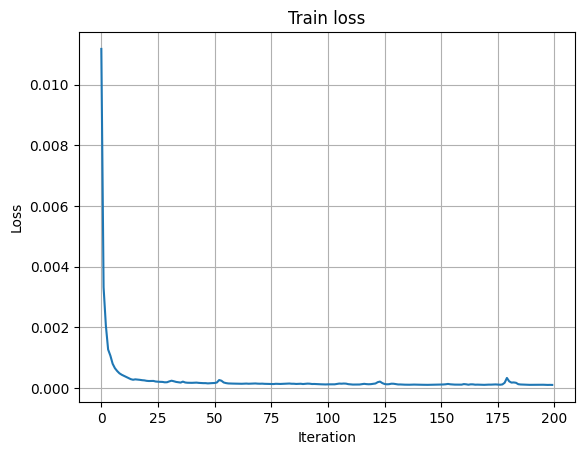

In [ ]:
plt.plot(history.history["loss"])
plt.title("Train loss")
plt.grid()
plt.xlabel("Iteration")
plt.ylabel("Loss")

1/1 [==============================] - 0s 17ms/step


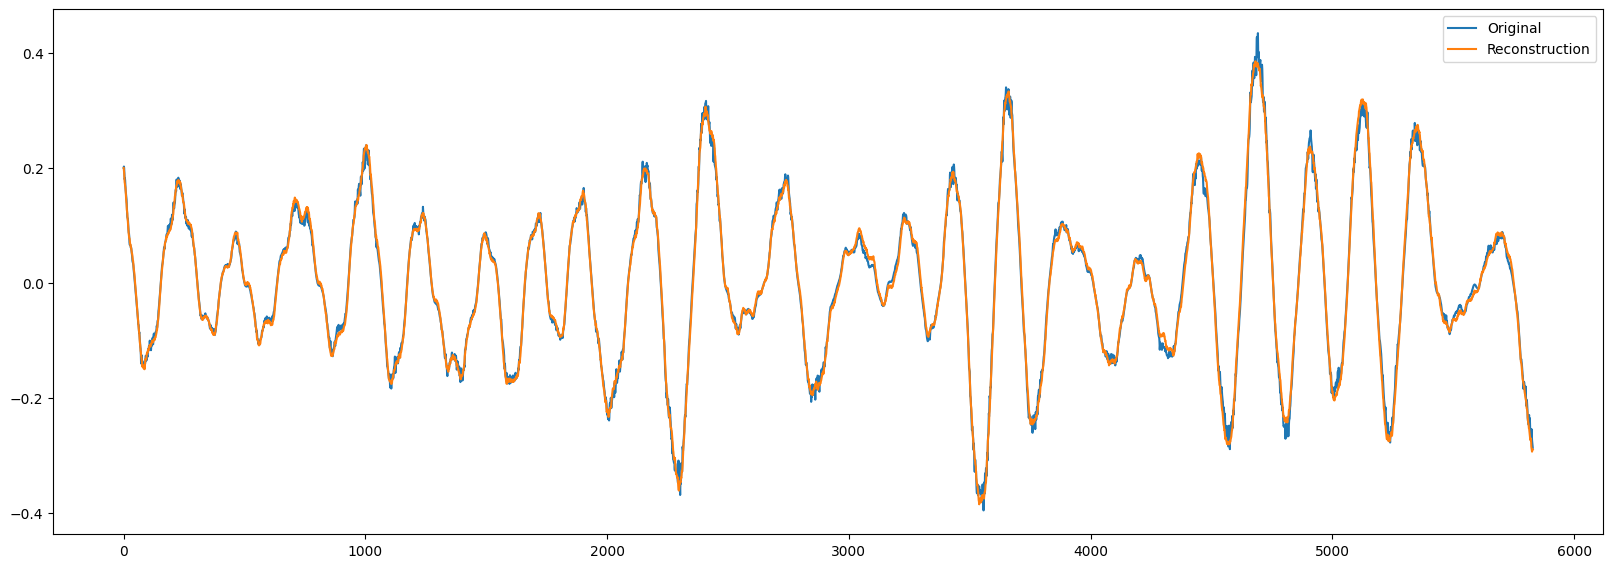

In [ ]:
num_terms = X_test_Vinte.shape[1]  # Corrigindo a definição de num_terms
x = np.arange(0, num_terms)
decoded_results = autoencoder.predict(X_test_Baseline[0:1])

plt.figure(figsize=(20, 15))

# Display original
ax = plt.subplot(2, 1, 1 + 1)
plt.plot(x, X_test_Baseline.iloc[0].values, label="Original")

# Display reconstruction
plt.plot(x, decoded_results[0], label="Reconstruction")

plt.legend()
plt.show()

Mahalanobis mae médio :  0.0


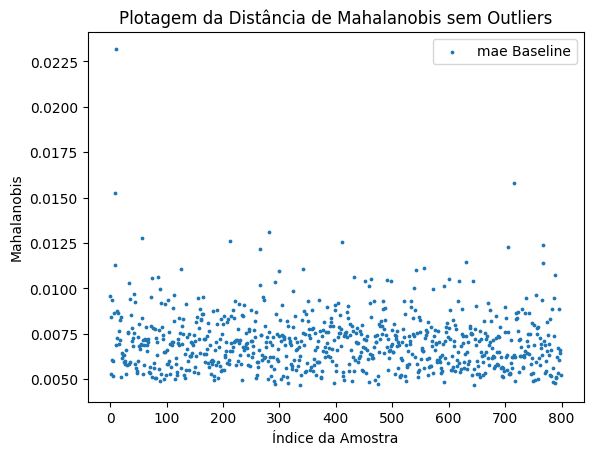

Mahalanobis mae médio :  0.6287755883312399


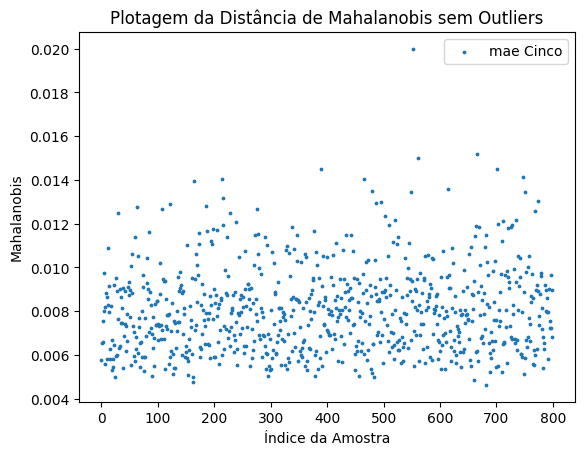

Mahalanobis mae médio :  1.746894882197805


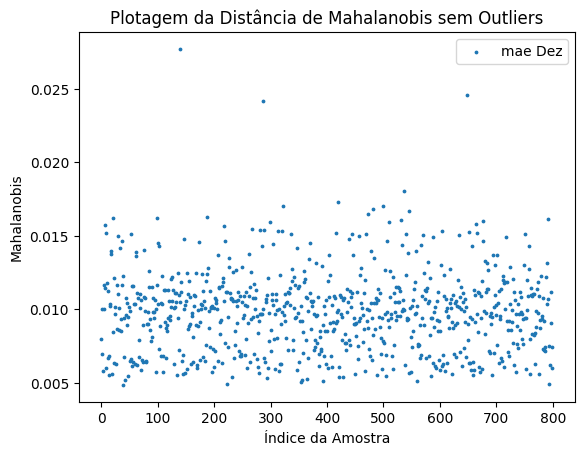

Mahalanobis mae médio :  5.12831663256201


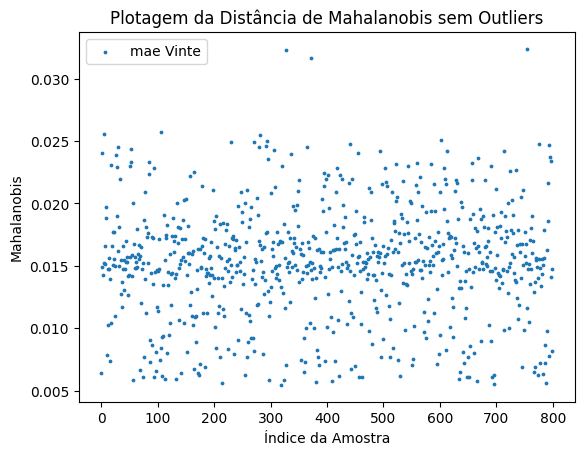

In [18]:
mae_Baseline = []  # Inicializar como uma lista

for i in range(dataBaseline_df.shape[0]):
    y = np.array(dataBaseline_df.iloc[i])
    y_predict = autoencoder.predict(dataBaseline_df.iloc[i].values.reshape(1, -1), verbose=0)
    y_predict = y_predict[0]
    mae_Atual = np.mean(np.abs((y_predict - y)))  # Calculando o mae atual e usando np.mean()
    mae_Baseline.append(mae_Atual)

mae_Baseline = np.array(mae_Baseline)

def mae_Dano(dadoAnalisado, autoencoder, mae_Baseline, label):
    mae_Medio = np.array([])

    for i in range(dadoAnalisado.shape[0]):
        y = np.array(dadoAnalisado.iloc[i])
        y_predict = autoencoder.predict(dadoAnalisado.iloc[i].values.reshape(1, -1), verbose=0)
        y_predict = y_predict[0]
        mae_Atual = np.mean(np.abs((y_predict - y)))  # Calculando o mae atual e usando np.mean()
        mae_Medio = np.append(mae_Medio, mae_Atual)
    
    mahalanobis = np.sqrt(((mae_Medio.mean() - mae_Baseline.mean()) ** 2) / (mae_Baseline.std()) ** 2)
   
    print(f"Mahalanobis mae médio : ", mahalanobis)
    x = np.arange(0,mae_Medio.shape[0])
    plt.scatter(x, mae_Medio, s = 3)
    plt.xlabel('Índice da Amostra')
    plt.ylabel('Mahalanobis')
    plt.title('Plotagem da Distância de Mahalanobis sem Outliers')
    plt.gca().legend((label,))
    plt.show()

    return mahalanobis, mae_Baseline, mae_Medio

# Chamar a função para cada cenário com a etiqueta apropriada
mae_baseline = mae_Dano(dataBaseline_df, autoencoder, mae_Baseline, 'mae Baseline')
mae_Cinco = mae_Dano(dataCincoP_df, autoencoder, mae_Baseline, 'mae Cinco')
mae_Dez = mae_Dano(dataDez_df, autoencoder, mae_Baseline, 'mae Dez')
mae_Vinte = mae_Dano(dataVinte_df, autoencoder, mae_Baseline, 'mae Vinte')


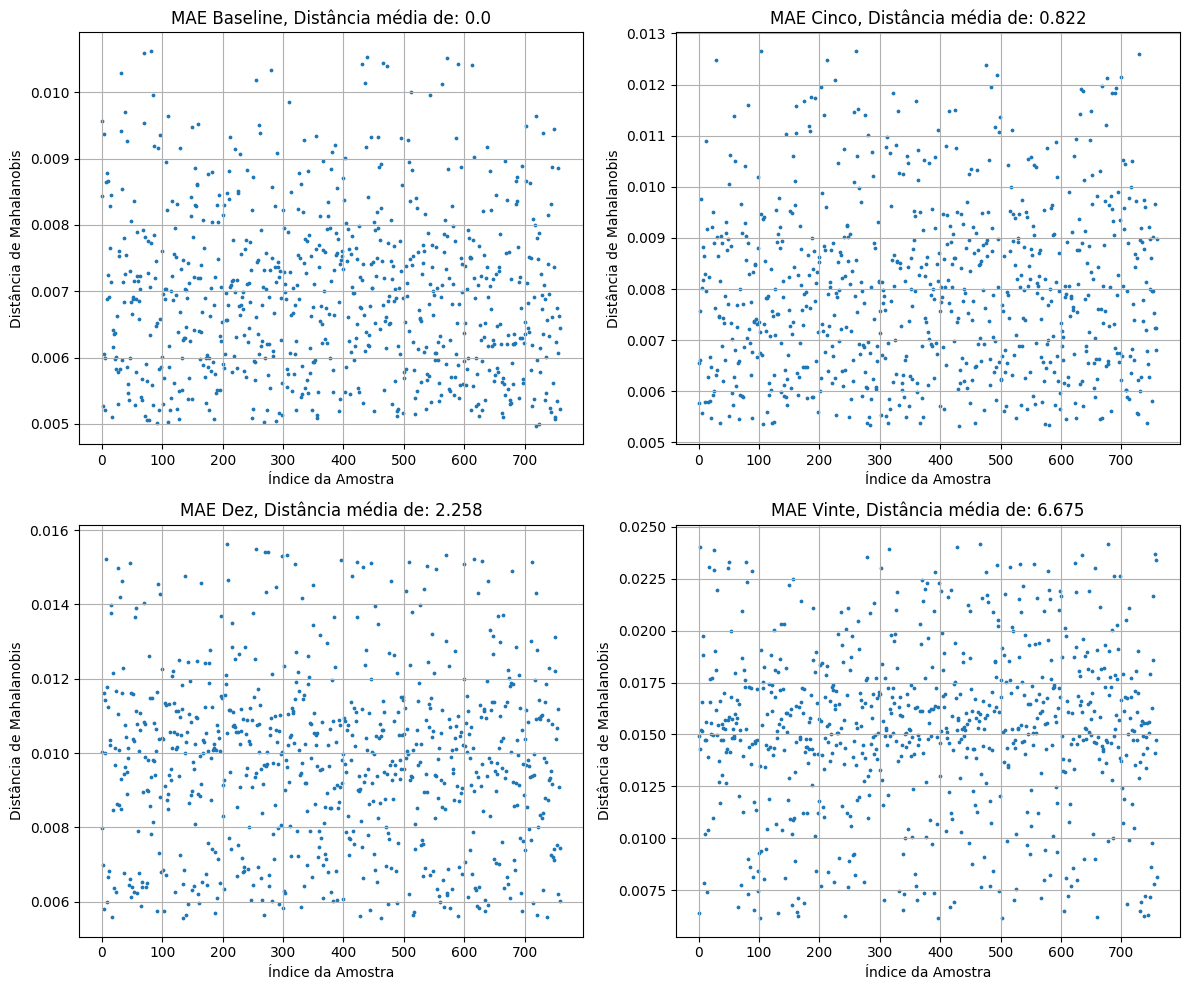

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Chamar a função para cada cenário com a etiqueta apropriada e plotar em um grid
for i, (mae_data, label) in enumerate([(mae_baseline, 'MAE Baseline'), (mae_Cinco, 'MAE Cinco'), (mae_Dez, 'MAE Dez'), (mae_Vinte, 'MAE Vinte')]):
    ax = axs[i // 2, i % 2]
    x = np.arange(0, mae_data[2].__len__())
    ax.scatter(x, mae_data[2], s=3)
    ax.set_xlabel('Índice da Amostra')
    ax.set_ylabel('Distância de Mahalanobis')
    ax.set_title(f'{label}, Distância média de: {np.round(mae_data[0],3)}')
    ax.grid(True)

plt.tight_layout()
plt.show()

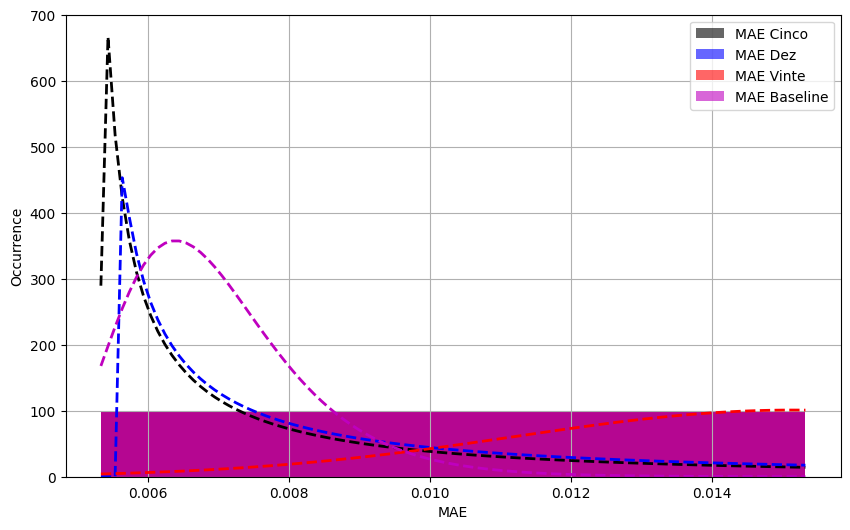

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import lognorm

bin_width = 0.01
bins = np.arange(min(mae_Cinco[2]), max(mae_Cinco[2]) + bin_width, bin_width)

# Plotando o histograma para mae_Cinco
plt.figure(figsize=(10,6))
plt.hist(mae_Cinco[2], bins=bins, density=True, alpha=0.6, color='black', label='MAE Cinco')

# Ajustando uma curva de distribuição lognormal aos dados de mae_Cinco
shape, loc, scale = lognorm.fit(mae_Cinco[2])
x = np.linspace(min(bins), max(bins), 100)
pdf = lognorm.pdf(x, shape, loc, scale)
plt.plot(x, pdf, 'k--', linewidth=2)

# Plotando o histograma para mae_Dez
plt.hist(mae_Dez[2], bins=bins, density=True, alpha=0.6, color='b', label='MAE Dez')

# Ajustando uma curva de distribuição lognormal aos dados de mae_Dez
shape, loc, scale = lognorm.fit(mae_Dez[2])
pdf = lognorm.pdf(x, shape, loc, scale)
plt.plot(x, pdf, 'b--', linewidth=2)

# Plotando o histograma para mae_Vinte
plt.hist(mae_Vinte[2], bins=bins, density=True, alpha=0.6, color='r', label='MAE Vinte')

# Ajustando uma curva de distribuição lognormal aos dados de mae_Vinte
shape, loc, scale = lognorm.fit(mae_Vinte[2])
pdf = lognorm.pdf(x, shape, loc, scale)
plt.plot(x, pdf, 'r--', linewidth=2)

# Plotando o histograma para mae_Baseline
plt.hist(mae_baseline[2], bins=bins, density=True, alpha=0.6, color='m', label='MAE Baseline')

# Ajustando uma curva de distribuição lognormal aos dados de mae_Baseline
shape, loc, scale = lognorm.fit(mae_baseline[2])
pdf = lognorm.pdf(x, shape, loc, scale)
plt.plot(x, pdf, 'm--', linewidth=2)

plt.xlabel('MAE')
plt.ylabel('Occurrence')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
train_loss = tf.keras.losses.mae(reconstructions_train, baseline_train)

              #Ajuste de uma distribuição normal para Y=ln(train_loss)
              train_norm_log = np.log(train_loss)
              normFittolog_train = scipy.stats.norm.fit(train_norm_log)

              MediaTrain[iter] = normFittolog_train[0]
              DesvioTrain[iter] = normFittolog_train[1]

In [ ]:
 for nc in range (ncenarios):
            for nb in range (n_vbatch):
                
                DKL = np.log(Desvio[nc,na,nb]/DesvioTrain)+((1/(2*(Desvio[nc,na,nb]**2)))*((DesvioTrain**2)+(Media[nc,na,nb]-MediaTrain)**2))-(1/2)      
                DI[nc, nb] = np.log(DKL+math.exp(1))-1 